In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
from modes.vortex import Vortex
from modes.zernike import Zernike
from modes.pixel import Pixel
from modes.functions import *


from sklearn import linear_model

device = 'cuda:4'


truncate_circle = False

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the Modes and the derivatives

In [2]:
microlens = 20 #20x20
size = microlens

n_zernike = 10

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront')

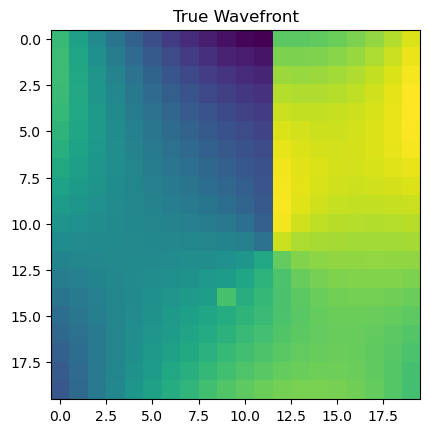

In [3]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2]

shift_zer, _, _ = Zernike(n_zernike,xx,yy,x0=decenter[0],y0=decenter[1],truncate_circle=truncate_circle)
shift_vor, _, _ = Vortex(1,xx,yy, x0=decenter[0],y0=decenter[1], truncate_circle=truncate_circle)
shift_pix, _, _ = Pixel(xx,yy)

modes = torch.concat((shift_zer,shift_vor,shift_pix),dim=0)
mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(n_zernike)
np.random.shuffle(elements)
elements = elements[:2]
zer_coeffs = torch.rand(len(elements),1,1)

mode_coeffs[elements] = zer_coeffs

mode_coeffs[n_zernike] = 1

mode_coeffs[300] = 1



wavefront = torch.sum(mode_coeffs * modes,dim=0)

plt.imshow(wavefront); plt.title('True Wavefront')

#### Lets calc gradients


In [4]:
dx, dy = torch.gradient(wavefront)

sampled_gradient = torch.stack((dx,dy),axis=0)

mode_gradients = get_mode_derivs([0,0], xx, yy, n_zernike=n_zernike, truncate_circle=False)

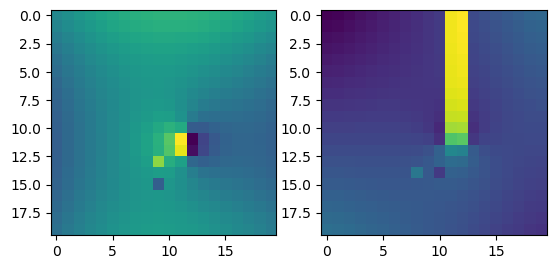

In [5]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sampled_gradient[0])
ax[1].imshow(sampled_gradient[1])

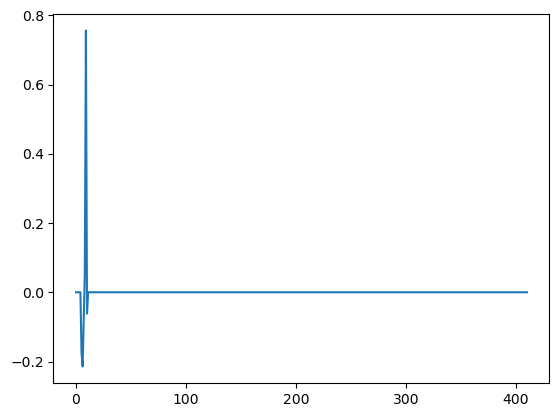

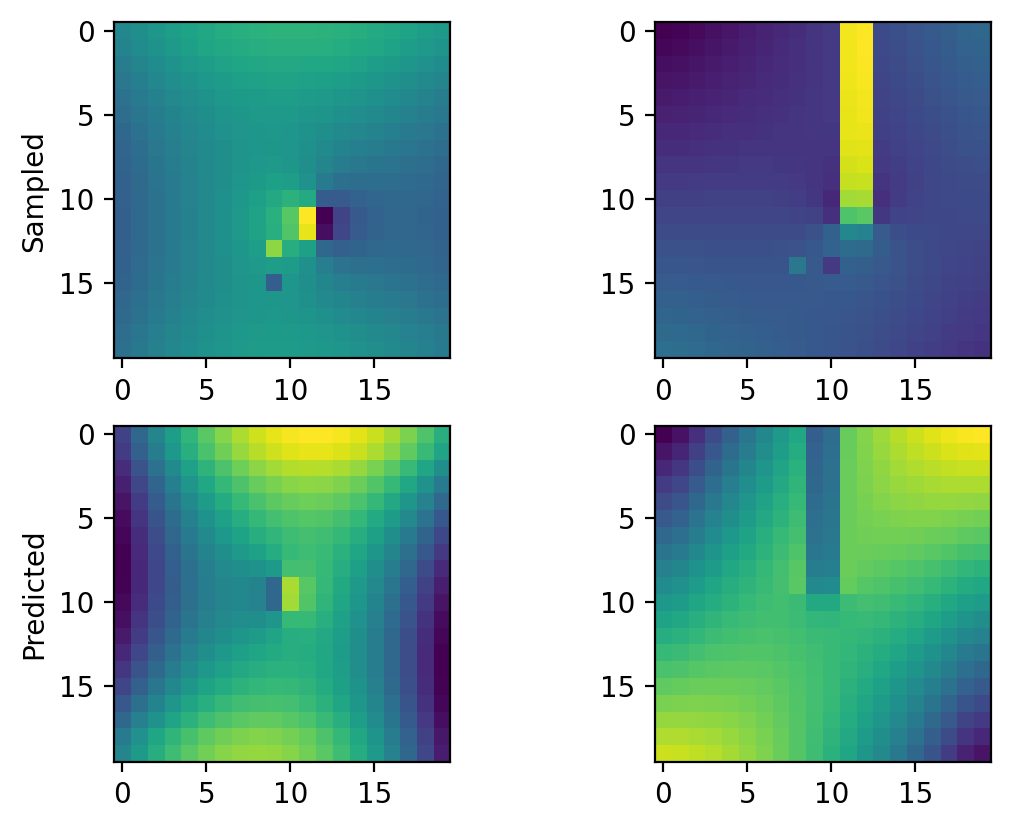

In [6]:
t = sampled_gradient.reshape(-1,1)
u = mode_gradients.permute(0,2,3,1).reshape(-1,mode_gradients.shape[1])

clf = linear_model.Lasso(alpha=0.01)
clf.fit(u,t)
result_vector = clf.coef_

wavefront_grad_prediction = (mode_gradients.permute(0,2,3,1) @ result_vector)
plt.figure()
plt.plot(result_vector)


fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(wavefront_grad_prediction[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(wavefront_grad_prediction[1])


In [7]:
u = torch.tensor(u).permute(1,0).float()

t = torch.tensor(t).permute(1,0).float().to(device)

/tmp/user/25186/ipykernel_3687737/2457971503.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u).permute(1,0).float()
/tmp/user/25186/ipykernel_3687737/2457971503.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).permute(1,0).float().to(device)


In [12]:
coefficients = torch.nn.Parameter(torch.rand(1,u.shape[0]).to(device))
offset = torch.nn.Parameter(torch.zeros(2))

reg_coeff = 5e-3


history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['loss'] = []


In [13]:
lr = 5e-4


epochs = 8000

optimizer = torch.optim.Adam([coefficients, offset], lr=lr)
loss_fn = torch.nn.MSELoss()



for epoch in range(1, epochs+1):
    # with torch.autograd.detect_anomaly():
        
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    # seq_model.train()
    num_train_examples = 1

    optimizer.zero_grad()

    mode_gradients = get_mode_derivs([offset[0],offset[1]], xx, yy, n_zernike=n_zernike, truncate_circle=False).permute(1,0,2,3).to(device)
    
    pred = (coefficients @ mode_gradients.reshape(mode_gradients.shape[0],-1))

    mse = loss_fn(pred, t)

    reg = torch.norm(coefficients,1) / coefficients.size()[0]

    loss = mse + reg * reg_coeff

    loss.backward()
    optimizer.step()

    



    print(f'Epoch {epoch}/{epochs}:, train mse: {mse:5.5g}, train reg: {reg*reg_coeff:5.5g}',end='\r')


    history2['loss'].append(loss.item())

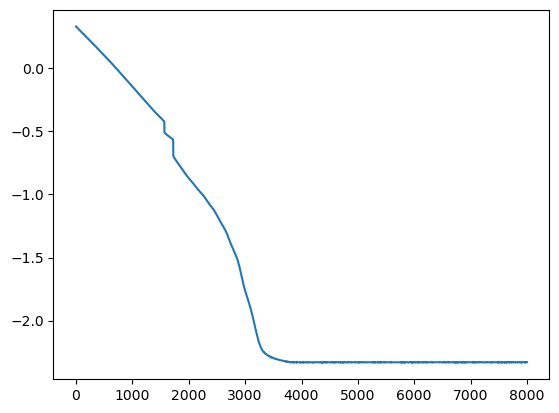

In [ ]:
plt.plot(np.log10(history2['loss']))

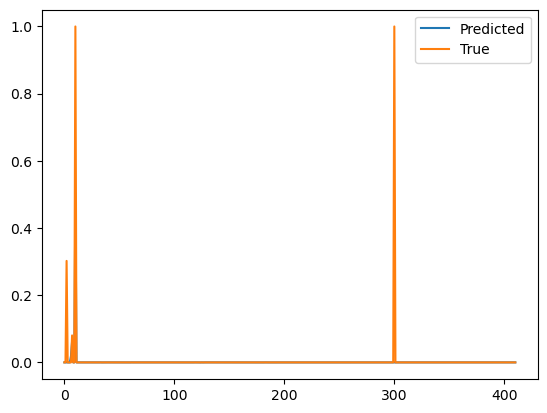

In [ ]:
plt.plot(coefficients[0].detach())
plt.plot(mode_coeffs[:,0,0])
plt.legend(['Predicted','True'])


In [ ]:
pred_gradients = pred.reshape(2,20,20).detach().numpy()

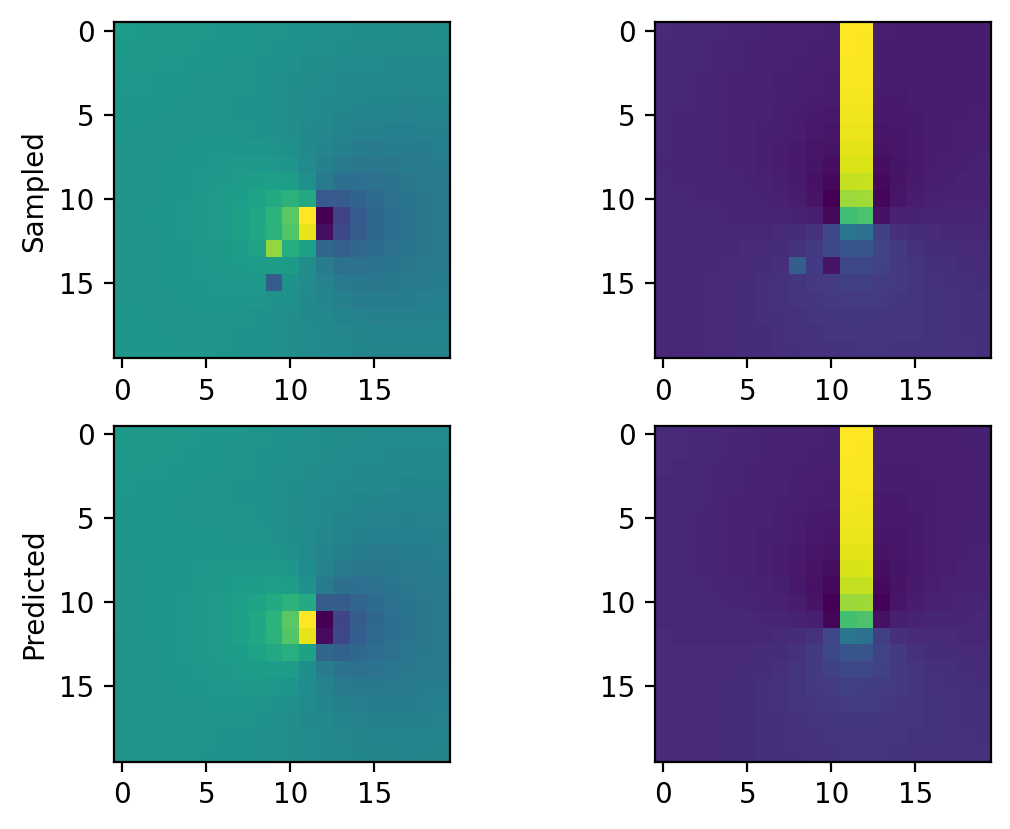

In [ ]:
fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(pred_gradients[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(pred_gradients[1])
